# Лабораторная 7. Сентимент-анализ

Задачи классификации текста аналогично обычной задаче классификации предполагает присвоение метки класса некоторому тексту. Здесь можно действовать любыми методами для того, чтобы классифицировать текст, но мы пойдем по следующему пути: векторизуем последовательности (обязательно почитайте про подходы к векторизации, об эмбеддингах) и обучим RNN

После обучения базовых моделей разрешается использовать любой другой подход

За выполнение базовой работы можно получить 15 баллов, за преодоление отметки в 94% точности классификации еще 5 баллов
Удачи!

Примечание: обязательно почитайте про лемматизацию, стеминг, TF-IDF и Word2Vec подходы

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from collections import Counter  
from string import punctuation  
from sklearn.metrics import accuracy_score 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder

from gensim.models import Word2Vec

import torch
import torch.nn as nn 
from torch.optim import Adam 
from torch.utils.data import DataLoader, TensorDataset

lemma = WordNetLemmatizer()
lb = LabelEncoder()

In [4]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Мария\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Мария\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Мария\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Мария\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [5]:
df = pd.read_csv('twitter_training.csv', header=None)
# Просмотр первых 5 строк данных
df.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [6]:
np.unique(df[1])

array(['Amazon', 'ApexLegends', 'AssassinsCreed', 'Battlefield',
       'Borderlands', 'CS-GO', 'CallOfDuty', 'CallOfDutyBlackopsColdWar',
       'Cyberpunk2077', 'Dota2', 'FIFA', 'Facebook', 'Fortnite', 'Google',
       'GrandTheftAuto(GTA)', 'Hearthstone', 'HomeDepot',
       'LeagueOfLegends', 'MaddenNFL', 'Microsoft', 'NBA2K', 'Nvidia',
       'Overwatch', 'PlayStation5(PS5)',
       'PlayerUnknownsBattlegrounds(PUBG)', 'RedDeadRedemption(RDR)',
       'TomClancysGhostRecon', 'TomClancysRainbowSix', 'Verizon',
       'WorldOfCraft', 'Xbox(Xseries)', 'johnson&johnson'], dtype=object)

In [7]:
# Удаление первого столбца
df = df.drop(0, axis=1)

In [8]:
# Переименовываем столбцы
df = df.rename(columns={1: "Feature2", 3: "Feature1", 2: "labels"})

In [9]:
df.head()

,Feature2,labels,Feature1
0,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,Borderlands,Positive,I am coming to the borders and I will kill you...
2,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,Borderlands,Positive,im coming on borderlands and i will murder you...
4,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [10]:
# Объединение текстовых данных из двух столбцов в один
df["tweets"]= df["Feature1"].astype(str) +" "+ df["Feature2"].astype(str)
# Удаление исходных текстовых столбцов
df= df.drop(["Feature1","Feature2"],axis=1)
df.head()

,labels,tweets
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [11]:
# Создание словаря для кодирования меток классов
df_labels = {key : value for value , key in enumerate(np.unique(df['labels']))}
df_labels

{'Irrelevant': 0, 'Negative': 1, 'Neutral': 2, 'Positive': 3}

In [12]:
# Функция для получения числовой метки по тексту
def getlabel(n):
    for x, y in df_labels.items():
        if y == n:
            return x

In [13]:
# Функция для предобработки текста
def DataPrep(text):
    text = re.sub('<.*?>', '', text)  # Удаляем HTML теги
    text = re.sub(r'\d+', '', text)  # Удаляем числа
    text = re.sub(r'[^\w\s]', '', text)  # Удаляем специальные символы
    text = re.sub(r'http\S+', '', text)  # Удаляем URL
    text = re.sub(r'@\S+', '', text)  # Удаляем упоминания
    text = re.sub(r'#\S+', '', text)  # Удаляем хештеги

    # Токенизация
    tokens = nltk.word_tokenize(text)

    # Удаляем пунктуацию
    punc = list(punctuation)
    words = [word for word in tokens if word not in punc]

    # Удаление стоп-слова
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word.lower() in stop_words]

    # Лемматизация
    words = [lemma.lemmatize(word) for word in words]

    # Возвращение слова обратно в строку
    text = ' '.join(words)

    return text


In [14]:
# Применение предобработки к каждому твиту
df['cleaned_tweets'] = df['tweets'].apply(DataPrep)

In [15]:
# Вывод количества дубликатов
print(f'There are around {int(df["cleaned_tweets"].duplicated().sum())} duplicated tweets, we will remove them.')

# Удаление дубликатов
df.drop_duplicates("cleaned_tweets", inplace=True)

# Добавление столбца с длиной твитов
df['tweet_len'] = [len(text.split()) for text in df.cleaned_tweets]

# Удаление твитов с длиной больше 99.5% квантиля
df = df[df['tweet_len'] < df['tweet_len'].quantile(0.995)]

There are around 11865 duplicated tweets, we will remove them.


C:\Users\Мария\AppData\Local\Temp\ipykernel_16352\3335825041.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='tweet_len', data=df[(df['tweet_len'] <= 1000) & (df['tweet_len'] > 10)], palette='Blues_r')


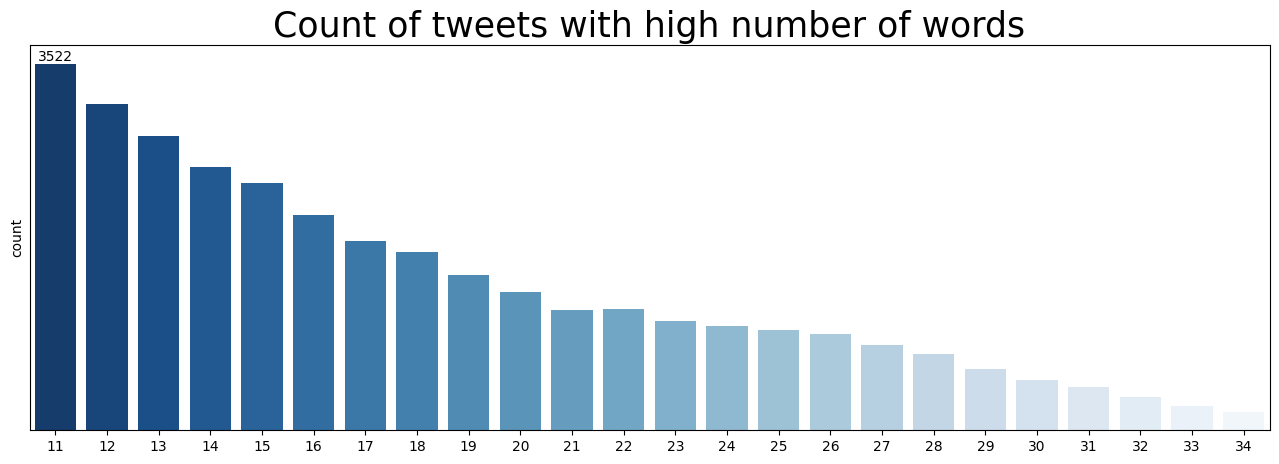

In [16]:
# Визуализация распределения длины твитов
plt.figure(figsize=(16, 5))
ax = sns.countplot(x='tweet_len', data=df[(df['tweet_len'] <= 1000) & (df['tweet_len'] > 10)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

## Обучаем модели

In [17]:
# Определение максимальной длины твитов
MAX_LEN = np.max(df['tweet_len'])


In [18]:
# Функция для подготовки текстовых данных для ввода в LSTM
def lstm_prep(column, seq_len):
    # Создаем корпус слов из всех текстов в колонке
    corpus = [word for text in column for word in text.split()]  # Объединяем слова из всех текстов
    words_count = Counter(corpus)  # Подсчитываем количество каждого слова
    sorted_words = words_count.most_common()  # Сортируем слова по убыванию частоты
    vocab_to_int = {w: i + 1 for i, (w, c) in enumerate(sorted_words)}  # Сопоставляем каждому слову уникальный индекс

    text_int = []  # Список для хранения текстов, преобразованных в индексы

    # Преобразуем каждый текст в последовательность индексов
    for text in column:
        token = [vocab_to_int[word] for word in text.split()]  # Заменяем слова их индексами
        text_int.append(token)  # Сохраняем последовательность индексов

    # Инициализируем массив для хранения последовательностей заданной длины
    features = np.zeros((len(text_int), seq_len), dtype=int)  # Массив нулей размером (количество текстов, seq_len)
    for idx, y in tqdm(enumerate(text_int)):  # Проходим по преобразованным текстам с индексацией
        if len(y) <= seq_len:  # Если длина текста меньше или равна заданной длине
            zeros = list(np.zeros(seq_len - len(y)))  # Создаем список из недостающих нулей
            new = zeros + y  # Дополняем текст нулями в начале
        else:  # Если текст длиннее, чем заданная длина
            new = y[:seq_len]  # Усекаем текст до нужной длины

        features[idx, :] = np.array(new)  # Заполняем массив подготовленной последовательностью

    # Возвращаем отсортированный список слов и подготовленные данные
    return sorted_words, features


In [19]:
# Подготавка данных для LSTM
VOCAB, tokenized_column = lstm_prep(df['cleaned_tweets'], MAX_LEN)

0it [00:00, ?it/s]

In [20]:
# Вывод первых 10 слов из словаря
VOCAB[:10]

[('game', 8616),
 ('like', 4206),
 ('Im', 3715),
 ('Microsoft', 3635),
 ('Facebook', 3633),
 ('get', 3621),
 ('Amazon', 3456),
 ('Verizon', 3411),
 ('Google', 3266),
 ('Battlefield', 3133)]

In [21]:
# Получение размеров токенизированного столбца
tokenized_column.shape


(62400, 34)

In [22]:
# Функция для визуализации самых частотных слов
def most_common_words(vocab):
    keys = []  # Список для хранения слов из словаря
    values = []  # Список для хранения частоты появления этих слов
    for key, value in vocab[:30]:  # Берем первые 30 слов из списка наиболее частотных
        keys.append(key)  # Добавляем слово в список ключей
        values.append(value)  # Добавляем частоту в список значений

    # Настройка параметров визуализации
    plt.figure(figsize=(15, 5))  # Задаем размеры графика (ширина, высота)
    ax = plt.bar(keys, values)  # Создаем столбчатую диаграмму с данными
    plt.title('Top 30 Most Common Words', size=25)  # Устанавливаем заголовок графика
    plt.ylabel("Word Frequency")  # Добавляем подпись к оси Y
    plt.xticks(rotation=45)  # Поворачиваем подписи на оси X для лучшей читаемости
    plt.subplots_adjust(bottom=0.15)  # Увеличиваем отступ снизу для подписей слов
    plt.show()  # Отображаем построенный график


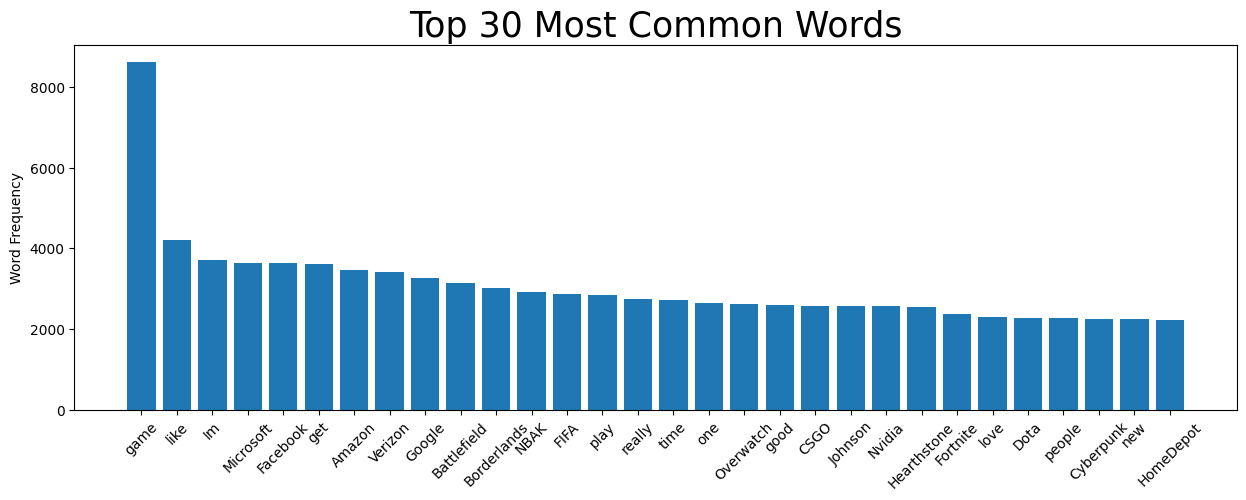

In [26]:
# Визуализируем самые распространенные слова
most_common_words(VOCAB)

In [28]:
# Определение X и y для обучения
X = tokenized_column
y = lb.fit_transform(df['labels'].values)  # Кодируем метки классов

In [29]:
# Разделение данных на обучающую и валидационную выборки
X_train, X_val, Y_train, Y_val = train_test_split(X, y, train_size=0.85, random_state=42)

In [30]:
# Создание датасета для PyTorch
train_data = TensorDataset(torch.from_numpy(X_train), torch.LongTensor(Y_train))
val_data = TensorDataset(torch.from_numpy(X_val), torch.LongTensor(Y_val))

In [31]:
 # Устанавливаем размер батча
BATCH_SIZE = 64

# Создаем загрузчики данных для обучающей и валидационной выборок
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True  # Перемешиваем данные
)
val_dataloader = DataLoader(
    dataset=val_data,
    batch_size=BATCH_SIZE,
    shuffle=False  # Не перемешиваем валидационные данные
)

In [32]:
# Устанавливаем размерность эмбеддингов
EMBEDDING_DIM = 200

In [33]:
Word2vec_train_data = list(map(lambda x: x.split(), df['cleaned_tweets']))  # Подготовка данные для Word2Vec
word2vec_model = Word2Vec(Word2vec_train_data, vector_size=EMBEDDING_DIM)  # Обучение модели Word2Vec


In [34]:
# Функция для создания матрицы весов эмбеддингов на основе предобученной модели
def weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1  # Определяем размер словаря (включая индекс 0 для пустых значений)
    embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))  # Инициализируем матрицу нулей для эмбеддингов
    for word, token in vocab:  # Перебираем каждое слово и его индекс из словаря
        if model.wv.__contains__(word):  # Проверяем, есть ли текущее слово в предобученной модели
            embedding_matrix[token] = model.wv.__getitem__(word)  # Копируем эмбеддинг слова в соответствующую строку матрицы
    return embedding_matrix  # Возвращаем готовую матрицу эмбеддингов


In [35]:
# Получаем матрицу весов эмбеддингов
embedding_vec = weight_matrix(word2vec_model, VOCAB)
print("Embedding Matrix Shape:", embedding_vec.shape)  # Вывод форму матрицы весов

Embedding Matrix Shape: (43365, 200)


In [36]:
# Функция для подсчета параметров модели
def param_count(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]  # Получаем количество параметров, требующих градиента
    print('The Total number of parameters in the model : ', sum(params))  # Выводим общее количество параметров

In [37]:
# Определяем архитектуру нейронной сети
class Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_layers, hidden_dim, out_channels, bidirectional, device='cpu'):
        super().__init__()  # Инициализируем родительский класс nn.Module
        print(device)  # Выводим используемое устройство (CPU или GPU)

        # Параметры модели
        self.no_layers = num_layers  # Количество слоев в LSTM
        self.hidden_dim = hidden_dim  # Размер скрытого слоя LSTM
        self.out_channels = out_channels  # Количество выходных нейронов (например, для классификации)
        self.num_directions = 2 if bidirectional else 1  # Учитываем количество направлений (1 для обычного, 2 для bidirectional)
        self.device = device  # Сохраняем устройство (CPU/GPU)

        # Слой эмбеддингов
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  # Создаем слой для преобразования индексов в эмбеддинги
        self.embedding = self.embedding.to(device)  # Переносим слой эмбеддингов на устройство

        # Слой LSTM
        self.lstm = nn.LSTM(
            embedding_dim,  # Размер входных данных (эмбеддинги)
            hidden_dim,  # Размер скрытого слоя
            num_layers,  # Количество слоев LSTM
            dropout=0.5,  # Dropout для регуляризации
            bidirectional=bidirectional,  # Использовать ли двунаправленную LSTM
            batch_first=True  # Указываем, что первым измерением идет размер батча
        )
        self.lstm = self.lstm.to(device)  # Переносим LSTM на устройство

        # Полносвязный слой
        self.fc = nn.Linear(hidden_dim * self.num_directions, out_channels)  # Выходной слой для классификации
        self.fc = self.fc.to(device)  # Переносим слой на устройство

    # Метод прямого прохода через модель
    def forward(self, x):
        # Инициализация скрытых состояний и ячеек памяти LSTM
        h0 = torch.zeros((self.no_layers * self.num_directions, x.size(0), self.hidden_dim)).to(self.device)  # h_0
        c0 = torch.zeros((self.no_layers * self.num_directions, x.size(0), self.hidden_dim)).to(self.device)  # c_0

        # Преобразование входных данных через слой эмбеддингов
        embedded = self.embedding(x)  # Получаем эмбеддинги для входных данных

        # Пропуск данных через слой LSTM
        out, _ = self.lstm(embedded, (h0, c0))  # Получаем выходы и скрытые состояния LSTM

        # Извлечение последнего выхода LSTM
        out = out[:, -1, :]  # Берем выход по последней временной точке для каждого примера

        # Пропуск через полносвязный слой
        out = self.fc(out)  # Получаем предсказания модели

        return out  # Возвращаем выход модели


In [38]:
# Определение параметров модели
VOCAB_SIZE = len(VOCAB) + 1  # Размер словаря (учитываем индекс 0 для пустых значений)
NUM_LAYERS = 2  # Количество слоев в LSTM
OUT_CHANNELS = 4  # Количество выходных классов для классификации
HIDDEN_DIM = 256  # Размер скрытого слоя LSTM
BIDIRECTIONAL = True  # Использовать ли двунаправленный LSTM
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  # Определяем устройство: GPU (если доступен) или CPU

# Создание экземпляра модели с заданными параметрами
model = Model(VOCAB_SIZE, EMBEDDING_DIM, NUM_LAYERS, HIDDEN_DIM, OUT_CHANNELS, BIDIRECTIONAL, DEVICE)

# Копирование весов эмбеддингов из заранее подготовленной матрицы
model.embedding.weight.data.copy_(torch.from_numpy(embedding_vec))  # Заполняем веса слоя эмбеддингов

# Разрешение обновления весов эмбеддингов в процессе обучения
model.embedding.weight.requires_grad = True  # Эмбеддинги будут обновляться при обучении

# Перенос модели на GPU, если доступен
if torch.cuda.is_available():
    model = model.cuda()  # Переносим модель на GPU


cpu


In [39]:
# счетчик параметров модели
param_count(model)

The Total number of parameters in the model :  11189996


In [44]:
# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()  # Функция потерь для многоклассовой классификации (перекрестная энтропия)
optimizer = Adam(model.parameters(), lr=0.001)  # Оптимизатор Adam с заданной скоростью обучения

# Установка количества эпох
epochs = 10  # Количество эпох для обучения
training_loss = []  # Список для хранения потерь на каждой эпохе
training_acc = []  # Список для хранения точности на каждой эпохе

# Цикл обучения
for i in tqdm(range(epochs)):  # Процесс обучения на протяжении заданного числа эпох
    epoch_loss = 0  # Суммарные потери за текущую эпоху
    epoch_acc = 0  # Суммарная точность за текущую эпоху
    for batch, (x_train, y_train) in enumerate(train_dataloader):  # Обработка данных по батчам
        x_train, y_train = x_train.to(DEVICE), y_train.to(DEVICE)  # Перенос данных на устройство (GPU/CPU)
        y_pred = model(x_train)  # Получаем предсказания модели

        loss = criterion(y_pred, y_train)  # Вычисление потерь на основе функции потерь

        if batch % 500 == 0:  # Каждые 500 батчей выводим информацию о процессе обучения
            print(f"Looked at {batch * len(x_train)}/{len(train_dataloader.dataset)} samples.")  # Прогресс обучения

        loss.backward()  # Обратный проход (вычисление градиентов)
        optimizer.step()  # Обновление параметров модели на основе градиентов
        optimizer.zero_grad()  # Обнуление градиентов для следующего шага

        epoch_loss += loss  # Суммируем потери за всю эпоху
        epoch_acc += accuracy_score(y_train.cpu(), y_pred.argmax(dim=1).cpu())  # Вычисляем точность на текущем батче

    # Сохранение усредненных потерь и точности за эпоху
    training_loss.append((epoch_loss / len(train_dataloader)).detach().cpu().numpy())  # Среднее значение потерь за эпоху
    training_acc.append(epoch_acc / len(train_dataloader))  # Средняя точность за эпоху

    # Вывод результатов обучения за текущую эпоху
    print(f"Epoch {i+1}: Accuracy: {(epoch_acc / len(train_dataloader)) * 100:.2f}%, Loss: {(epoch_loss / len(train_dataloader)):.4f}\n\n")


  0%|          | 0/10 [00:00<?, ?it/s]

Looked at 0/53040 samples.
Looked at 32000/53040 samples.
Epoch 1: Accuracy: 62.85%, Loss: 0.8929


Looked at 0/53040 samples.
Looked at 32000/53040 samples.
Epoch 2: Accuracy: 89.53%, Loss: 0.3051


Looked at 0/53040 samples.
Looked at 32000/53040 samples.
Epoch 3: Accuracy: 94.47%, Loss: 0.1610


Looked at 0/53040 samples.
Looked at 32000/53040 samples.
Epoch 4: Accuracy: 96.14%, Loss: 0.1105


Looked at 0/53040 samples.
Looked at 32000/53040 samples.
Epoch 5: Accuracy: 97.15%, Loss: 0.0827


Looked at 0/53040 samples.
Looked at 32000/53040 samples.
Epoch 6: Accuracy: 97.66%, Loss: 0.0656


Looked at 0/53040 samples.
Looked at 32000/53040 samples.
Epoch 7: Accuracy: 98.07%, Loss: 0.0532


Looked at 0/53040 samples.
Looked at 32000/53040 samples.
Epoch 8: Accuracy: 98.34%, Loss: 0.0448


Looked at 0/53040 samples.
Looked at 32000/53040 samples.
Epoch 9: Accuracy: 98.63%, Loss: 0.0394


Looked at 0/53040 samples.
Looked at 32000/53040 samples.
Epoch 10: Accuracy: 98.79%, Loss: 0.0341



## Время Prediction

In [46]:
# Загружаем тестовый набор данных из CSV файла
test_df = pd.read_csv('twitter_validation.csv', header=None)
print(test_df.head())  # Выводим первые 5 строк для проверки

# Удаляем первый столбец (индексы)
test_df = test_df.drop(0, axis=1)

# Переименовываем столбцы для удобства
test_df = test_df.rename(columns={1: "Feature2", 3: "Feature1", 2: "labels"})
test_df.head()  # Проверяем изменения

      0          1           2  \
0  3364   Facebook  Irrelevant   
1   352     Amazon     Neutral   
2  8312  Microsoft    Negative   
3  4371      CS-GO    Negative   
4  4433     Google     Neutral   

                                                   3  
0  I mentioned on Facebook that I was struggling ...  
1  BBC News - Amazon boss Jeff Bezos rejects clai...  
2  @Microsoft Why do I pay for WORD when it funct...  
3  CSGO matchmaking is so full of closet hacking,...  
4  Now the President is slapping Americans in the...  


,Feature2,labels,Feature1
0,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,Google,Neutral,Now the President is slapping Americans in the...


In [47]:
# Объединяем тексты из двух столбцов в один столбец "tweets"
test_df["tweets"] = test_df["Feature1"].astype(str) + " " + test_df["Feature2"].astype(str)

# Удаляем старые столбцы Feature1 и Feature2
test_df = test_df.drop(["Feature1", "Feature2"], axis=1)

In [48]:
test_df.head()

,labels,tweets
0,Irrelevant,I mentioned on Facebook that I was struggling ...
1,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,Negative,@Microsoft Why do I pay for WORD when it funct...
3,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,Neutral,Now the President is slapping Americans in the...


In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Создание векторизатора TF-IDF для преобразования текста в числовые векторы
vec = TfidfVectorizer(max_features=5000)  # Ограничиваем количество признаков (максимум 5000)

# Обучаем векторизатор на обучающих данных
vec.fit(df['tweets'])  # Преобразуем тексты твитов в векторы TF-IDF

# Функция для выполнения предсказаний на случайных твитах
def make_predictions(row):
    # Случайным образом выбираем 10 твитов из тестового набора
    random_data = row.sample(n=10, random_state=42)  # Фиксируем random_state для воспроизводимости результатов
    random_tweets = random_data['tweets'].values  # Извлекаем текстовые данные твитов

    # Очищаем текст твитов перед преобразованием в векторы
    cleaned_tweets = [DataPrep(tweet) for tweet in random_tweets]  # Используем list comprehension для удобства

    # Преобразуем очищенные твиты в векторы с помощью обученного векторизатора
    x_test = vec.transform(cleaned_tweets).toarray()  # Преобразуем текст в числовые векторы

    # Извлекаем истинные метки классов для сравнения с предсказаниями
    y_test = random_data['labels'].values  # Истинные метки классов твитов

    # Подготавливаем данные для подачи в LSTM модель
    _, X_test = lstm_prep(cleaned_tweets, MAX_LEN)  # Преобразуем текст в формат, подходящий для LSTM
    X_test = torch.from_numpy(X_test).to(DEVICE)  # Переводим данные в тензор и отправляем на нужное устройство

    # Получаем предсказания от LSTM модели
    lstm_pred = model(X_test)  # Получаем предсказания из модели
    lstm_pred = torch.softmax(lstm_pred, dim=1).argmax(dim=1)  # Применяем softmax для вероятностей и выбираем класс с наибольшей вероятностью

    # Преобразуем индексы предсказанных классов обратно в метки
    pred = np.array([getlabel(lstm_pred[i]) for i in range(len(lstm_pred))])

    # Выводим оригинальные твиты, их метки и предсказания модели
    for i in tqdm(range(2)):  # Ограничиваем вывод первых двух твитов для примера
        print(f"The original tweet : {random_tweets[i]}\n")  # Оригинальный текст твита
        print(f"The original label : {y_test[i]}\n")  # Истинная метка для твита
        print(f"The lstm prediction is : {getlabel(lstm_pred[i])}\n")  # Предсказанная моделью метка
        print('-' * 120)  # Разделитель для улучшения читаемости

    # Вычисляем и выводим точность предсказаний
    accuracy = accuracy_score(pred, y_test)  # Сравниваем предсказанные и истинные метки
    print(f'Accuracy of predictions: {accuracy:.2f}')  # Выводим точность предсказаний с двумя знаками после запятой

# Вызов функции для выполнения предсказаний на тестовом наборе данных
make_predictions(test_df)


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

The original tweet : Remote working and an increase in cloud-based data is spurring cyber-attacks: Today sees the publication of the Verizon Business 2020 Data Breach Investigations Report which shows that network security is even more important ... dlvr.it/RX3fdK EXETLOS Verizon

The original label : Positive

The lstm prediction is : Negative

------------------------------------------------------------------------------------------------------------------------
The original tweet : I actually quite like the design of the ps5. It truly feels like the next generation of a console rather than just being a bulkier box with more power PlayStation5(PS5)

The original label : Positive

The lstm prediction is : Negative

------------------------------------------------------------------------------------------------------------------------
Accuracy of predictions: 0.20


## Что дальше?

Попытайтесь улучшить модель (попробуйте GRU), изменить подход к токенизации данных и так далее, удачи!